In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
%matplotlib inline

In [37]:
# Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWjXMXLeKtILhuqBdiaVEs4Vhw7ePQtFFhIXGWwQPpFU2tcmXnEweM8
Mounted at /content/drive


In [38]:
# Unzip small_data
!unzip /content/drive/MyDrive/Master_Thesis/small_data.zip

Archive:  /content/drive/MyDrive/Master_Thesis/small_data.zip
  inflating: small_data.npy          


In [48]:
# Read all_target
all_target = pd.read_csv('/content/drive/MyDrive/Master_Thesis/all_target.csv')

# Read small_data
small_data = np.load('small_data.npy')

# split dataset into train-test
from sklearn.model_selection import train_test_split
X_train, y_train, X_test, y_test = train_test_split(small_data, all_target, test_size=0.3, random_state=42)

In [40]:
all_target.head(5)

,CEAP
0,1
1,6
2,2
3,2
4,1


In [41]:
small_data.shape

(81, 10, 512, 512)

In [44]:
small_data[:2]

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

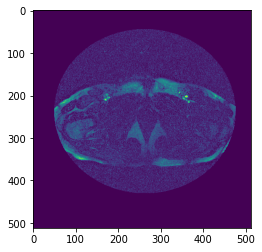

In [45]:
patient_images = small_data[0]
plt.imshow(patient_images[0])
plt.show()

In [46]:
patient_images = small_data[0]

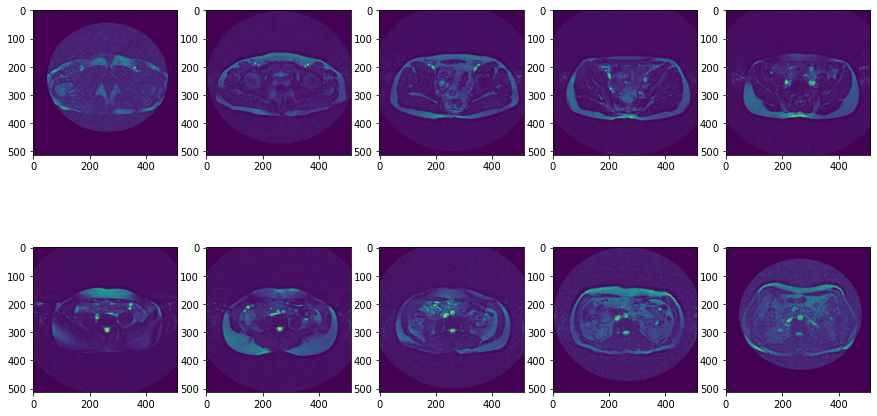

In [47]:
nbRows = 2
nbCols = 5
fig, axis = plt.subplots(nbRows, nbCols, figsize=(15, 8))
for row in range(nbRows):
  for col in range(nbCols):
    axis[row][col].imshow(patient_images[row*nbCols+col])

## CNN

In [61]:
cnn = models.Sequential([
                        
  # cnn
  layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(10, 512, 512)),
  layers.MaxPool2D(2, 2),
  layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(2, 2),
  layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
  layers.MaxPool2D(2, 2),
  layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),

  # dense
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(6, activation='softmax')
])

cnn.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

cnn.fit(X_train, y_train, epochs=10)

ValueError: ignored

In [ ]:
|

# From the toturial in the youtube


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
X_train.shape

170508288/170498071 [==============================] - 6s 0us/step


(50000, 32, 32, 3)

In [3]:
X_test.shape

(10000, 32, 32, 3)

In [4]:
y_train.shape

(50000, 1)

In [5]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

In [6]:
y_train = y_train.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [7]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [8]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
def plot_samples(X, y, index):
  plt.figure(figsize = (15, 2))
  plt.imshow(X[index])
  plt.xlabel(classes[y[index]])

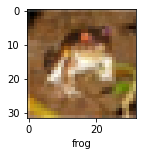

In [10]:
plot_samples(X_train, y_train, 0)

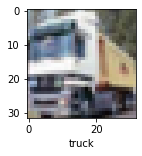

In [11]:
plot_samples(X_train, y_train, 1)

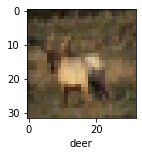

In [12]:
plot_samples(X_train, y_train, 3)

In [13]:
X_train = X_train / 255
X_test = X_test / 255

In [14]:
ann = models.Sequential([
    layers.Flatten(input_shape = (32, 32, 3)),
    layers.Dense(3000, activation = 'relu'),
    layers.Dense(1000, activation = 'relu'),
    layers.Dense(10, activation = 'sigmoid')
])

ann.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = 'accuracy')

ann.fit(X_train, y_train, epochs=5)

Epoch 1/5
1563/1563 [==============================] - 15s 8ms/step - loss: 1.8778 - accuracy: 0.3340
Epoch 2/5
1563/1563 [==============================] - 13s 8ms/step - loss: 1.6587 - accuracy: 0.4066
Epoch 3/5
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5791 - accuracy: 0.4362
Epoch 4/5
1563/1563 [==============================] - 13s 8ms/step - loss: 1.5280 - accuracy: 0.4523
Epoch 5/5
1563/1563 [==============================] - 13s 8ms/step - loss: 1.4930 - accuracy: 0.4650


In [25]:
ann.evaluate(X_test, y_test)

313/313 [==============================] - 8s 25ms/step - loss: 1.4988 - accuracy: 0.4660


[1.498816967010498, 0.4659999907016754]

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = ann.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification report: \n", classification_report(y_test, y_pred_classes))

Classification report: 
               precision    recall  f1-score   support

           0       0.59      0.37      0.46      1000
           1       0.64      0.53      0.58      1000
           2       0.28      0.46      0.35      1000
           3       0.31      0.34      0.33      1000
           4       0.46      0.26      0.34      1000
           5       0.50      0.21      0.30      1000
           6       0.41      0.67      0.51      1000
           7       0.52      0.52      0.52      1000
           8       0.51      0.71      0.59      1000
           9       0.61      0.47      0.53      1000

    accuracy                           0.46     10000
   macro avg       0.48      0.46      0.45     10000
weighted avg       0.48      0.46      0.45     10000



In [25]:
cnn = models.Sequential([
    # cnn
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    # dense
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(10, activation = 'softmax')
])


In [26]:
cnn.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

cnn.fit(X_train, y_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4969 - accuracy: 0.4600
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1473 - accuracy: 0.5977
Epoch 3/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0118 - accuracy: 0.6482
Epoch 4/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9312 - accuracy: 0.6775
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8652 - accuracy: 0.6983
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8141 - accuracy: 0.7176
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7668 - accuracy: 0.7337
Epoch 8/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7248 - accuracy: 0.7471
Epoch 9/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6871 - accuracy: 0.7595
Epoch 10/10
1563/1563 [==============================] - 10s 6ms/step - l

In [27]:
cnn.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.9258 - accuracy: 0.6929


[0.9257760643959045, 0.6929000020027161]

In [28]:
y_test = y_test.reshape(-1,)
y_test[:5]

array([3, 8, 8, 0, 6], dtype=uint8)

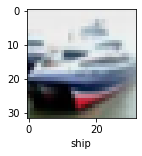

In [29]:
plot_samples(X_test, y_test, 1)

In [30]:
y_pred = cnn.predict(X_test)
y_pred[:5]

array([[1.5418111e-02, 1.7266597e-04, 6.5548387e-03, 7.0277208e-01,
        2.7623682e-03, 1.4345425e-01, 5.3197905e-02, 1.8760856e-03,
        6.2562004e-02, 1.1229580e-02],
       [3.2916494e-02, 2.4284865e-01, 1.5446545e-05, 4.0385530e-05,
        3.6584495e-06, 1.8604690e-07, 5.0600264e-08, 2.2975664e-06,
        7.0293307e-01, 2.1239726e-02],
       [1.2156353e-01, 1.3334745e-01, 1.8976260e-03, 8.7917047e-03,
        2.7830957e-03, 2.9281148e-04, 7.2558271e-04, 7.5953552e-03,
        6.8362534e-01, 3.9377492e-02],
       [9.4705522e-01, 6.1208527e-03, 1.7005101e-02, 1.3048855e-03,
        1.8819564e-03, 8.5542990e-05, 2.1734324e-04, 7.7530532e-04,
        2.5380477e-02, 1.7322495e-04],
       [2.1583501e-04, 2.4030362e-05, 3.1082729e-02, 2.9783482e-03,
        8.7891877e-01, 2.6384415e-03, 8.4077984e-02, 3.5327295e-05,
        1.8585630e-05, 9.9724684e-06]], dtype=float32)

In [32]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[3, 8, 8, 0, 4]

In [33]:
y_test[:5]

array([3, 8, 8, 0, 6], dtype=uint8)

In [35]:
print('Classification report: \n', classification_report(y_test, y_classes))

Classification report: 
               precision    recall  f1-score   support

           0       0.68      0.81      0.74      1000
           1       0.84      0.76      0.79      1000
           2       0.64      0.51      0.57      1000
           3       0.55      0.42      0.48      1000
           4       0.61      0.66      0.64      1000
           5       0.56      0.67      0.61      1000
           6       0.73      0.81      0.77      1000
           7       0.71      0.74      0.72      1000
           8       0.83      0.78      0.80      1000
           9       0.79      0.77      0.78      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

